In [1]:
import os.path as op
import numpy as np
import mne
from mne.cov import compute_covariance,compute_raw_covariance
from mne.beamformer import make_lcmv, apply_lcmv_cov
from scipy.signal import welch
import matplotlib.pyplot as plt

Set the paths and name for the data. Note that these will depend on your local setup.

In [2]:
result_path = r'C:\newdata'
file_name = 'rest_epoch.fif'
path_file  = op.join(result_path,file_name) 


### The forward model

For this example we will use a forward model already calculated. Please refer to the <a href="https://mne.tools/dev/auto_tutorials/forward/30_forward.html">MNE documentation</a> for how to calculate the forward model using FreeSurfer.

In [3]:
fwd_name = 'T1_anon_defaced-volume_fwd.fif'
fwd_fname = op.join(result_path,fwd_name) 
fwd = mne.read_forward_solution(fwd_fname)

Reading forward solution from C:\newdata\T1_anon_defaced-volume_fwd.fif...
    Reading a source space...
    [done]
    1 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (12135 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame


This is the forward model constructed for the 306 MEG sensors with respect to the brain surface of 8195 sources (grid points).

# Read the trials and plot the power spectra in the sensors

Now read the epochs for all trial types combined, and plot the power spectra for the epochs data from 1 to 200Hz and scalp topography of PSD for alpha band. We here focus on the alpha band modulations; therefore bandpass filter the data at 8 to 12 Hz and select the gradiometer data only:

Reading C:\newdata\rest_epoch.fif ...


C:\Users\daizhongpengMNE\AppData\Local\Temp\ipykernel_38512\2504768514.py:1: RuntimeWarning: This filename (C:\newdata\rest_epoch.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(path_file)


    Found the data of interest:
        t =       0.00 ...    9999.00 ms
        0 CTF compensation matrices available
Not setting metadata
26 matching events found
No baseline correction applied
0 projection items activated
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...
NOTE: plot_psd_topomap() is a legacy function. New code should use .compute_psd().plot_topomap().


C:\Users\daizhongpengMNE\anaconda3\envs\mne\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


    Using multitaper spectrum estimation with 7 DPSS windows


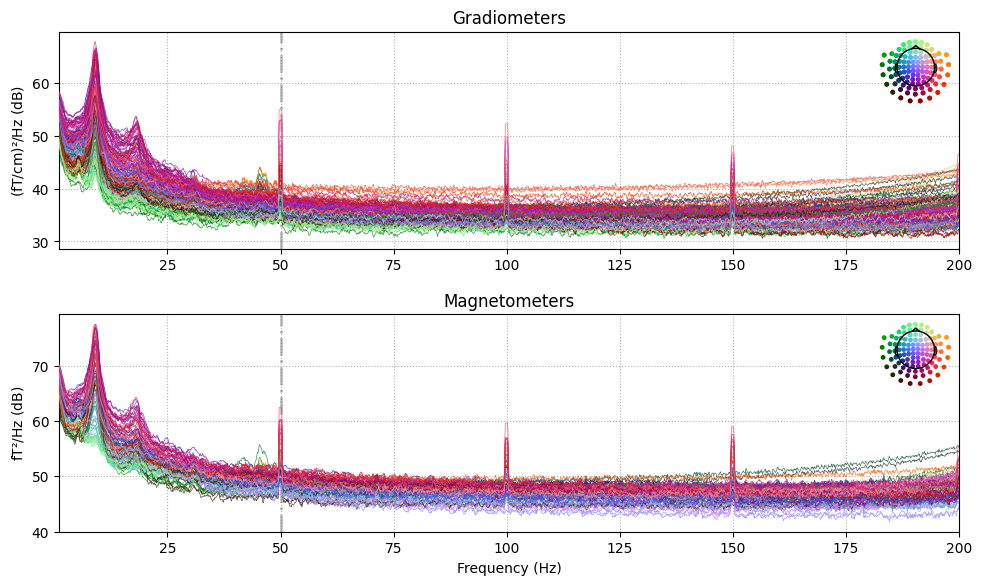

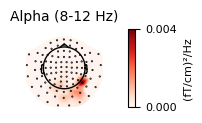

Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 1651 samples (1.651 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 5304 out of 5304 | elapsed:    5.5s finished


In [4]:
epochs = mne.read_epochs(path_file)
epochs.plot_psd(fmin=1, fmax=200)
epochs.plot_psd_topomap(bands={'Alpha (8-12 Hz)':(8, 12)},ch_type='grad', normalize=True)
epochs = epochs.pick_types(meg='grad')
epochs = epochs.filter(8, 12).copy()

### Calculating the covariance matrices 

The spatial filters in the LCMV beamforming approach are calculated using the forward model and the covariance matrices. The covarience matrices are calculated for each interval in order to later create a common spatial filter.

In [5]:
rank = mne.compute_rank(epochs, tol=1e-6, tol_kind='relative')
common_cov = compute_covariance(epochs,method = 'empirical' ,rank=rank,n_jobs = 4,verbose=True)

Computing rank from data with rank=None
    Estimated rank (grad): 69
    GRAD: rank 69 computed from 204 data channels with 0 projectors
Computing rank from data with rank={'grad': 69}
    Setting small GRAD eigenvalues to zero (without PCA)
Reducing data rank from 204 -> 69
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 260000
[done]


### Estimating a noise covariance with the empty room data

Estimate noise covariance matrix from a continuous segment of raw data. It is typically useful to estimate a noise covariance from empty room data.

In [6]:
noise_raw_list = list()
path_file = r'C:\newdata\sub_2001_ses_02B_task_noise_run_01_meg.fif'
noise_raw = mne.io.read_raw_fif(path_file, allow_maxshield=True,preload=True,verbose=True)
noise_raw = noise_raw.filter(8, 12).copy()
noise_cov = compute_raw_covariance(noise_raw, tmin=0, tmax=None, tstep=0.2, reject=None, 
                       flat=None, picks=None, method='empirical', method_params=None, 
                       cv=3, scalings=None, n_jobs=None, return_estimators=False, 
                       reject_by_annotation=True, rank=None, verbose=None)

Opening raw data file C:\newdata\sub_2001_ses_02B_task_noise_run_01_meg.fif...
Isotrak not found
    Read a total of 8 projection items:
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
    Range : 9000 ... 294999 =      9.000 ...   294.999 secs
Ready.
Reading 0 ... 285999  =      0.000 ...   285.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    5.1s finished


Using up to 1430 segments
Number of samples used : 286000
[done]


Lets now consider the rank for the coveriance matrix: 

Note that the rank is 69 eventhough there were 204 gradiometers used in the calculations. The rank deficiency is caused by the SSS algorithm and therefore requires a regulatization before inverting in the beamforming calculation. 

### Derive the spatial filters

Now calculate the filters using the forward model (*fwd*) and the combined covariance matrix (*common_cov*). The filters were regularized corresponding to loading the diagonal of the covariance matrix with 5% of the sensor power. The noise covariance was calculated with the empty room data. For each source the orientation was optimized to maximize the power of the output.The rank of the denominator of the beamformer formula (i.e., during pseudo-inversion) will be reduced by one for each spatial location. No depth weighting is performed. All three dipoles at a source vertex are considered as a group and the spatial filters are computed jointly using a matrix inversion. The unit-noise gain minimum variance beamformer will be computed.

In [7]:
filters = make_lcmv(epochs.info, 
                            fwd, 
                            common_cov, 
                            reg=0.05,
                            noise_cov=noise_cov, 
                            rank = rank,
                            pick_ori='max-power',
                            reduce_rank = True,
                            depth = 0,
                            inversion = 'matrix',
                            weight_norm = 'unit-noise-gain'
                            ) 

Computing rank from covariance with rank={'grad': 69}
Computing rank from covariance with rank={'grad': 69}
Making LCMV beamformer with rank {'grad': 69}
Computing inverse operator with 204 channels.
    204 out of 306 channels remain after picking
Selected 204 channels
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 3)
Computing rank from covariance with rank={'grad': 69}
    Setting small GRAD eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing beamformer filters for 12135 sources
Filter computation complete


### Apply the spatial filters

Then apply the filter to the data:

In [8]:
stc = apply_lcmv_cov(common_cov,filters)

### Plotting the source results

Showing: t = 0.000 s, (13.1, -57.0, -29.2) mm, [18, 6, 15] vox, 18036 vertex
Using control points [ 5.05388012  5.96044873 11.69204218]


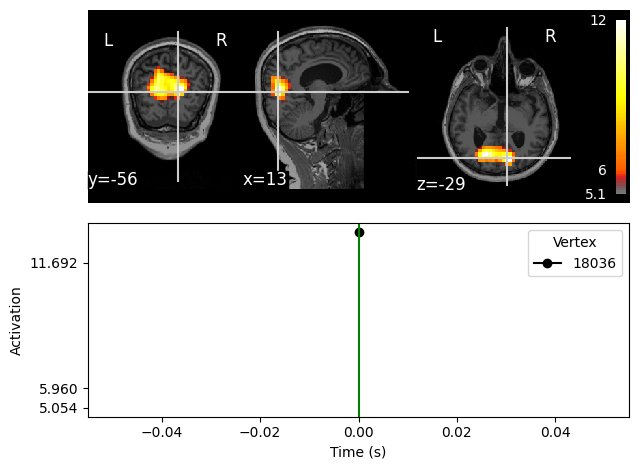

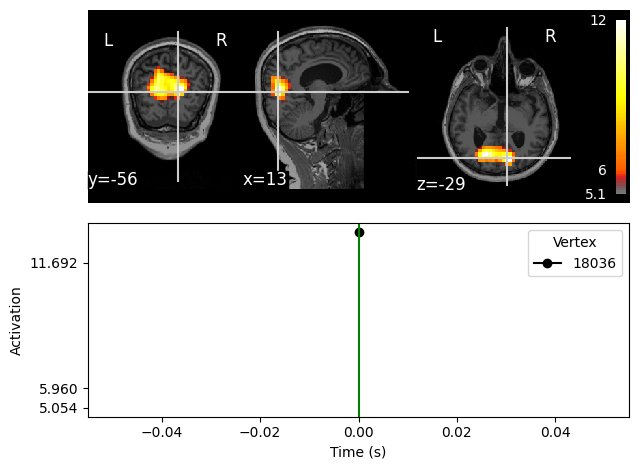

In [9]:
stc.plot(src=fwd['src'], subject='T1_anon_defaced', subjects_dir=r'C:\MSc_Project\Data_Control\sub001_20220609_b5e4', 
              mode='stat_map')

### Calculate time-series for source-volume data

Calculate source volumes' timeseries of partial epoches and extract the label of vertices showing the strong alpha oscillations 

In [11]:
from mne.beamformer import apply_lcmv_epochs
nepochs = 15
epochs1 = epochs[0: nepochs] 
stc1 = apply_lcmv_epochs(epochs1,filters)
mean_stc = np.sum(stc1) / len(stc1) 
# Define a threshold to determine significant activations
activation_threshold = 5.0  # Adjust as per your requirements

# Identify the vertices that exceed the threshold
significant_vertices = np.where(stc.data >= activation_threshold)[0]

Processing epoch : 1
Processing epoch : 2
Processing epoch : 3
Processing epoch : 4
Processing epoch : 5
Processing epoch : 6
Processing epoch : 7
Processing epoch : 8
Processing epoch : 9
Processing epoch : 10
Processing epoch : 11
Processing epoch : 12
Processing epoch : 13
Processing epoch : 14
Processing epoch : 15
[done]


### Plot source power spectra of the vertices showing strong alpha oscillations

Calculate source volumes' timeseries of partial epoches and extract the label of vertices showing the strong alpha oscillations 

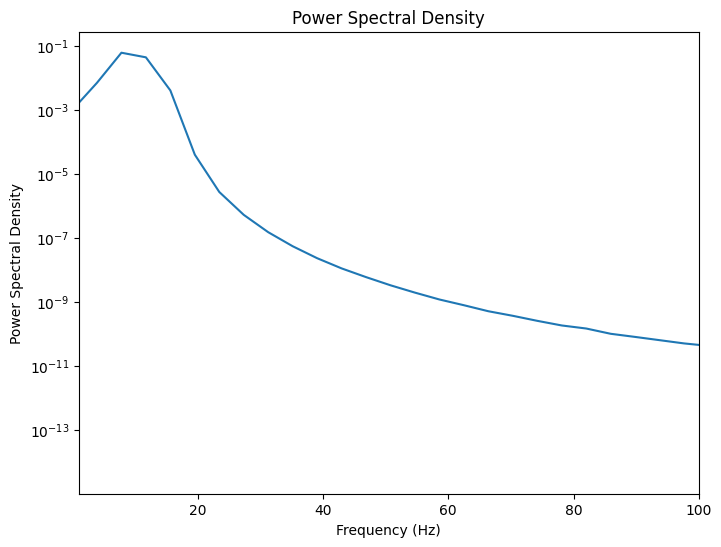

In [13]:
# Extract the time series data from the source estimate
time_series = mean_stc.data

# Define the sampling frequency
sfreq = mean_stc.sfreq

# Compute the PSD using Welch's method
frequencies, psd = welch(time_series[significant_vertices,:], fs=sfreq, nperseg=1024)

# Plot the power spectra
plt.figure(figsize=(8, 6))
plt.semilogy(frequencies, psd.mean(axis=0))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.title('Power Spectral Density')
plt.xlim([1, 100])
plt.show()

### Do parcellation with FreeSurfer MRI data

We extract brain regions' timeseries with the aparc.a2009s+aseg.mgz template

In [14]:
tc = mne.extract_label_time_course(mean_stc, 
                                   labels=r'C:\MSc_Project\Data_Control\sub001_20220609_b5e4\T1_anon_defaced\mri\aparc.a2009s+aseg.mgz', 
                                   src=fwd['src'], mode='mean')
label_names = mne.get_volume_labels_from_aseg(r'C:/MSc_Project/Data_Control/sub001_20220609_b5e4/T1_anon_defaced/mri/aparc.a2009s+aseg.mgz')

# Print the list of label names
print(label_names)

Reading atlas C:\MSc_Project\Data_Control\sub001_20220609_b5e4\T1_anon_defaced\mri\aparc.a2009s+aseg.mgz
190/190 atlas regions had at least one vertex in the source space
Extracting time courses for 190 labels (mode: mean)
['Unknown', 'Left-Cerebral-White-Matter', 'Left-Lateral-Ventricle', 'Left-Inf-Lat-Vent', 'Left-Cerebellum-White-Matter', 'Left-Cerebellum-Cortex', 'Left-Thalamus-Proper', 'Left-Caudate', 'Left-Putamen', 'Left-Pallidum', '3rd-Ventricle', '4th-Ventricle', 'Brain-Stem', 'Left-Hippocampus', 'Left-Amygdala', 'CSF', 'Left-Accumbens-area', 'Left-VentralDC', 'Left-vessel', 'Left-choroid-plexus', 'Right-Cerebral-White-Matter', 'Right-Lateral-Ventricle', 'Right-Inf-Lat-Vent', 'Right-Cerebellum-White-Matter', 'Right-Cerebellum-Cortex', 'Right-Thalamus-Proper', 'Right-Caudate', 'Right-Putamen', 'Right-Pallidum', 'Right-Hippocampus', 'Right-Amygdala', 'Right-Accumbens-area', 'Right-VentralDC', 'Right-vessel', 'Right-choroid-plexus', 'WM-hypointensities', 'Optic-Chiasm', 'CC_Poste

### References
Van Veen, B.D, van Drongelen, W., Yuchtman, M., and Suzuki, A. (1997). Localization of brain electrical activity via linearly constrained minimum variance spatial filtering. IEEE Transactions on Biomedical Engineering, 44(9):867–880.       